# Try ISIC Dataset loader

### Imports

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.dataset.isic import ISICDataset
from src.feature_extraction import unseggnet_extract, unseggnet_feature_extractor
from src.utils import unseggnet_utils

2025-01-07 10:52:10.621495: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 10:52:10.628607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736243530.637912   23923 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736243530.640703   23923 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 10:52:10.650458: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Load the data

In [2]:
path = '/home/meriem-mk/Downloads/ISBI2016_ISIC_Part3B_Training_Data'
dataset = ISICDataset(
    root=path,
    return_mask=True
)


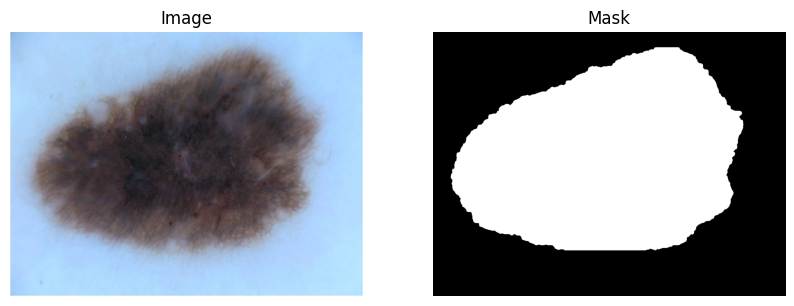

In [3]:
data = dataset[0]


image = data['image']  
mask = data['mask']    


if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy() 
if isinstance(mask, torch.Tensor):
    mask = mask.squeeze(0).numpy()       


plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")
plt.axis("off")


plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()

In [4]:
image = data['image']  
mask = data['mask'] 

# convert to numpy arrays
image = np.array(image)
mask = np.array(mask)

## Try passing the data to the feature extractor used in UNSEGGNET 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pretrained_weights = './dino_deitsmall8_pretrain_full_checkpoint.pth'
if not os.path.exists(pretrained_weights):
    url = 'https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_pretrain/dino_deitsmall8_pretrain_full_checkpoint.pth'
    unseggnet_utils.download_url(url, pretrained_weights)
extractor = unseggnet_feature_extractor.ViTExtractor(model_dir=pretrained_weights, device=device)

/home/meriem-mk/Image_Segmentation_With_GNNs/notebooks/../src/feature_extraction/unseggnet_feature_extractor.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict 

In [6]:
image_tensor, image = unseggnet_utils.load_data_img(image, (224, 224))
image_tensor.shape

torch.Size([1, 3, 224, 224])

In [7]:
F = unseggnet_extract.deep_features(image_tensor, extractor, device='cpu')

In [8]:
W = unseggnet_utils.create_adj(F, "DMON", 0)